# COMP90089 MLP model

## Import Library

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from captum.attr import IntegratedGradients, visualization
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [19]:
full_data = pd.read_csv("final_dataset_preprocessed_corrected.csv")

full_data.columns

Index(['hr_min', 'hr_max', 'NIMAP_min', 'NIMAP_max', 'mean_glucose',
       'max_glucose', 'min_glucose', 'valuenum', 'mean_temperature',
       'min_temperature', 'max_temperature', 'mean_RR', 'min_RR', 'max_RR',
       'min_creatinine', 'max_creatinine', 'avg_creatinine', 'min_potassium',
       'max_potassium', 'avg_potassium', 'min_ph', 'max_ph', 'avg_ph',
       'min_sodium', 'max_sodium', 'avg_sodium', 'anchor_age',
       'gender_numeric', 'label'],
      dtype='object')

In [20]:
full_data['label'].value_counts()

label
0    42057
1     4042
Name: count, dtype: int64

### Produce training and testing data

In [21]:
# np.random.seed(90089)
# y = full_data['label'].to_numpy()

# class_0_indices = np.where(y == 0)[0]
# class_1_indices = np.where(y == 1)[0]

# # Determine the number of samples you want for each class in the test set
# num_class_0_test = 1000
# num_class_1_test = 1000 

# # Randomly select test samples from each class
# class_0_test_indices = np.random.choice(class_0_indices, num_class_0_test, replace=False)
# class_1_test_indices = np.random.choice(class_1_indices, num_class_1_test, replace=False)

# # Combine selected test indices and remove them from the original sets
# test_indices = np.concatenate([class_0_test_indices, class_1_test_indices])
# train_indices = np.setdiff1d(np.arange(len(y)), test_indices)

# # Create train and test sets
# training, testing = full_data.iloc[train_indices], full_data.iloc[test_indices]
# training.to_csv('full_training.csv')
# testing.to_csv('full_testing.csv')

### Data preprocessing

In [22]:
feature_columns = ['hr_min', 'hr_max', 'NIMAP_min', 'NIMAP_max', 'mean_glucose',
       'max_glucose', 'min_glucose', 'valuenum', 'mean_temperature',
       'min_temperature', 'max_temperature', 'mean_RR', 'min_RR', 'max_RR',
       'min_creatinine', 'max_creatinine', 'avg_creatinine', 'min_potassium',
       'max_potassium', 'avg_potassium', 'min_ph', 'max_ph', 'avg_ph',
       'min_sodium', 'max_sodium', 'avg_sodium', 'anchor_age',
       'gender_numeric']
label_columns = ['label']

In [23]:
# X_train, X_test, y_train, y_test = train_test_split(full_data[feature_columns], full_data[label_columns], test_size=0.2, stratify=full_data[label_columns], random_state=90089)
train_df = pd.read_csv("full_training.csv")
test_df = pd.read_csv("full_testing.csv")
X_train, y_train = train_df[feature_columns], train_df[label_columns]
X_test, y_test = test_df[feature_columns], test_df[label_columns]

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
oversampling = SMOTE(sampling_strategy=0.3, random_state=90089)
X_train, y_train = oversampling.fit_resample(X_train, y_train)
y_train.value_counts()

label
0        41057
1        12317
Name: count, dtype: int64

### Model training

In [26]:
# Custom dataset to load images and labels from the CSV file
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data, label):
    self.data = data
    self.labels = label

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    data = self.data[idx]
    label = self.labels.iloc[idx].values

    return torch.tensor(np.array(data, dtype=np.float32)), torch.tensor(np.array(label, dtype=np.float32))

class TestDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    data = self.data.iloc[idx].values

    return torch.tensor(np.array(data, dtype=np.float32)), idx


In [27]:
# class Baseline_net(nn.Module):
#     def __init__(self):
#         super(Baseline_net, self).__init__()

#         self.fc1 = nn.Linear(len(X_train[0]), 32)
#         self.fc2 = nn.Linear(32, 32)
#         self.fc3 = nn.Linear(32, 16)
#         self.fc4 = nn.Linear(16, 2)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.relu(x)
#         x = self.fc4(x)
#         # Apply softmax to x
#         output = F.log_softmax(x, dim=1)
#         return output

class Baseline_net(nn.Module):
    def __init__(self):
        super(Baseline_net, self).__init__()

        self.fc1 = nn.Linear(len(X_train[0]), 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_classes=2, num_epochs=10):
  model = model.to(device)
  training_accuracy = []
  training_loss = []
  validation_accuracy = []
  validation_loss = []
  training_accuracy_labels = np.empty((num_epochs,num_classes))
  validation_accuracy_labels = np.empty((num_epochs,num_classes))

  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    # Training phase
    # Set model to training mode
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_corrects_labels = torch.zeros(num_classes)

    for inputs, labels in train_loader:
      if num_classes == 2:
        labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward pass
      outputs = model(inputs)
      labels = torch.squeeze(labels, dim=1)
      # Compute loss
      loss = criterion(outputs, labels)

      # Get predictions by finding maximum
      _, prediction = torch.max(outputs, 1)

      # Backpropagation
      loss.backward()
      # Update weights
      optimizer.step()

      # Track loss and accuracy
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(prediction == labels.data)

      for label in torch.unique(labels.data):
        running_corrects_labels[label] = running_corrects_labels[label] + torch.sum((prediction == labels.data) * (labels.data == label))

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
    correct_labels = running_corrects_labels.to('cpu').numpy()
    for label in np.unique(train_loader.dataset.labels):
      training_accuracy_labels[epoch,label] = correct_labels[label] / np.sum(train_loader.dataset.labels == label)

    # Validation phase
    # Set model to evaluation mode
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    # 6 labels, 2 lables if 2 class classification
    val_corrects_labels = torch.zeros(num_classes)

    # Disable gradient calculation
    with torch.no_grad():
      for inputs, labels in val_loader:
        if num_classes == 2:
          labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        labels = torch.squeeze(labels, dim=1)
        # Compute loss
        loss = criterion(outputs, labels)
        # Get predictions by finding maximum
        _, prediction = torch.max(outputs, 1)

        # Track loss and accuracy
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(prediction == labels.data)
        for label in torch.unique(labels.data):
          val_corrects_labels[label] = val_corrects_labels[label] + torch.sum((prediction == labels.data) * (labels.data == label))

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.4f}')

    correct_labels = val_corrects_labels.to('cpu').numpy()
    for label in np.unique(val_loader.dataset.labels):
      validation_accuracy_labels[epoch,label] = correct_labels[label] / np.sum(val_loader.dataset.labels == label)

    # Record statistics per epoch
    training_accuracy.append(epoch_acc)
    training_loss.append(epoch_loss)
    validation_accuracy.append(val_epoch_acc)
    validation_loss.append(val_epoch_loss)

  print('Complete')
  return training_accuracy, training_loss, validation_accuracy, validation_loss, training_accuracy_labels, validation_accuracy_labels

In [29]:
# Load dataset
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_dataset = CustomDataset(X_test, y_test)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=True)

model_to_train = Baseline_net()

Train the model here

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

class_weights = torch.tensor([len(y_train) / y_train.value_counts()[0], len(y_train) / y_train.value_counts()[1]], dtype=torch.float32).to(device)

optimizer = optim.Adam(model_to_train.parameters(), lr=0.001, weight_decay=0.002)
criterion = nn.CrossEntropyLoss(weight=class_weights)


train_acc, train_loss, valid_acc, valid_loss, train_acc_label, val_acc_label = train_model(model_to_train, train_loader, eval_loader, criterion, optimizer, device, num_epochs=20)

Using:  cuda
Epoch 1/20
Train Loss: 0.5924, Train Acc: 0.6792


d:\python_env\comp90086_env\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\aufb\AppData\Local\Temp\ipykernel_25048\1749586859.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  training_accuracy_labels[epoch,label] = correct_labels[label] / np.sum(train_loader.dataset.labels == label)


Validation Loss: 0.5866, Validation Acc: 0.6945
Epoch 2/20


C:\Users\aufb\AppData\Local\Temp\ipykernel_25048\1749586859.py:90: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  validation_accuracy_labels[epoch,label] = correct_labels[label] / np.sum(val_loader.dataset.labels == label)


Train Loss: 0.5597, Train Acc: 0.6934
Validation Loss: 0.5966, Validation Acc: 0.6945
Epoch 3/20
Train Loss: 0.5497, Train Acc: 0.7010
Validation Loss: 0.6123, Validation Acc: 0.7025
Epoch 4/20
Train Loss: 0.5437, Train Acc: 0.7045
Validation Loss: 0.6264, Validation Acc: 0.6995
Epoch 5/20
Train Loss: 0.5395, Train Acc: 0.7069
Validation Loss: 0.5946, Validation Acc: 0.7060
Epoch 6/20
Train Loss: 0.5360, Train Acc: 0.7091
Validation Loss: 0.6107, Validation Acc: 0.7070
Epoch 7/20
Train Loss: 0.5347, Train Acc: 0.7115
Validation Loss: 0.6299, Validation Acc: 0.7045
Epoch 8/20
Train Loss: 0.5321, Train Acc: 0.7126
Validation Loss: 0.6151, Validation Acc: 0.6990
Epoch 9/20
Train Loss: 0.5309, Train Acc: 0.7125
Validation Loss: 0.6279, Validation Acc: 0.6900
Epoch 10/20
Train Loss: 0.5292, Train Acc: 0.7142
Validation Loss: 0.6441, Validation Acc: 0.6975
Epoch 11/20
Train Loss: 0.5279, Train Acc: 0.7132
Validation Loss: 0.6529, Validation Acc: 0.6945
Epoch 12/20
Train Loss: 0.5265, Train A

### Evaluation

In [31]:
def test_model(model, test_loader, device):
  result = []
  model.to(device)
  model.eval()
  with torch.no_grad():
    for inputs, index in test_loader:
      inputs = inputs.to(device)
      index = index.cpu().numpy()

      # Forward pass
      outputs = model(inputs)
      # Get predictions by finding maximum
      _, prediction = torch.max(outputs, 1)
      prediction = prediction.cpu().numpy()
      for i in range(len(prediction)):
          result.append(prediction[i])
  return pd.DataFrame(result)

In [32]:
test_dataset = TestDataset(X_test)
test_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)
result = test_model(model_to_train, test_loader, device)

In [33]:
result.value_counts()

0
0    1043
1     957
Name: count, dtype: int64

In [45]:
print(classification_report(y_test, result, digits=4))
print(roc_auc_score(y_test, result))

              precision    recall  f1-score   support

           0     0.6894    0.7190    0.7039      1000
           1     0.7064    0.6760    0.6909      1000

    accuracy                         0.6975      2000
   macro avg     0.6979    0.6975    0.6974      2000
weighted avg     0.6979    0.6975    0.6974      2000

0.6975


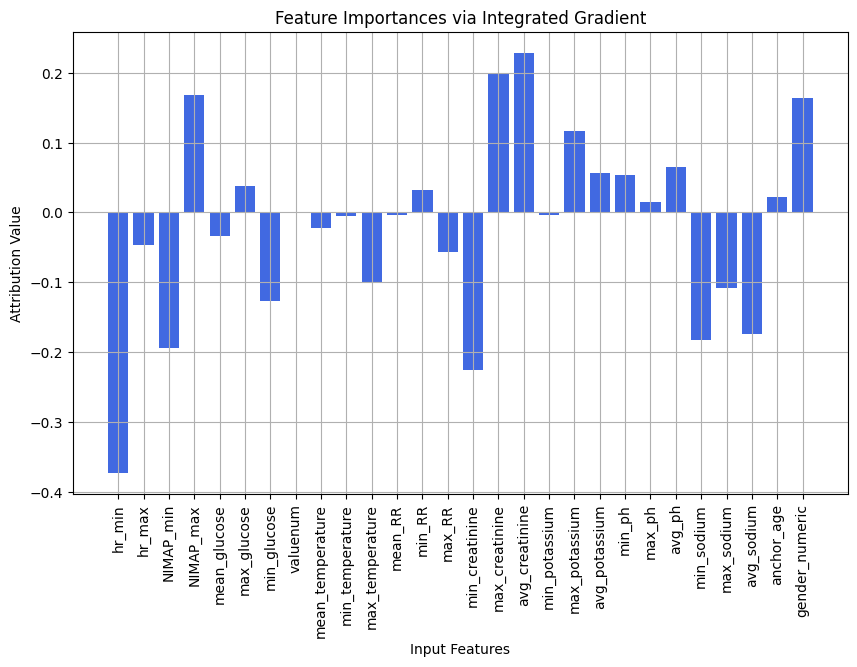

In [44]:
input_data = torch.tensor([X_test[0], ], dtype=torch.float32)

target_class = torch.tensor([y_test.iloc[0].values, ])

input_data.to('cpu')
target_class.to('cpu').type(torch.LongTensor)
model_to_train.to('cpu')


optimizer = optim.Adam(model_to_train.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

ig = IntegratedGradients(model_to_train)

attributions_ig = ig.attribute(input_data, target=target_class).cpu().detach().numpy()

attr_np = attributions_ig[0]

plt.figure(figsize=(10, 6))
plt.bar(feature_columns, attr_np, color='royalblue')
plt.xticks(rotation=90)
plt.xlabel("Input Features")
plt.ylabel("Attribution Value")
plt.title("Feature Importances via Integrated Gradient")
plt.grid()
plt.show()

## Visualising Results

In [36]:
train_acc_values = [x.item() for x in train_acc]
valid_acc_values = [x.item() for x in valid_acc]

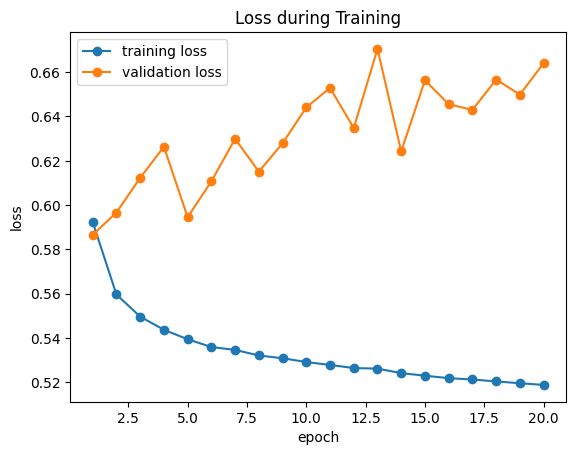

In [37]:
# fig, axes = plt.subplots(1,2, figsize=(12,5))

epochs = np.linspace(1,20,20)
# axes[0].plot(epochs,train_acc_values,"o-", label="training accuracy")
# axes[0].plot(epochs,valid_acc_values,"o-", label="validation accuracy")
# axes[0].set_xlabel("epoch")
# axes[0].set_ylabel("accuracy")
# axes[0].set_title("Accuracy of Baseline Model during Training")
# axes[0].legend()

plt.plot(epochs,train_loss,"o-", label="training loss")
plt.plot(epochs,valid_loss,"o-", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss during Training")
plt.legend()

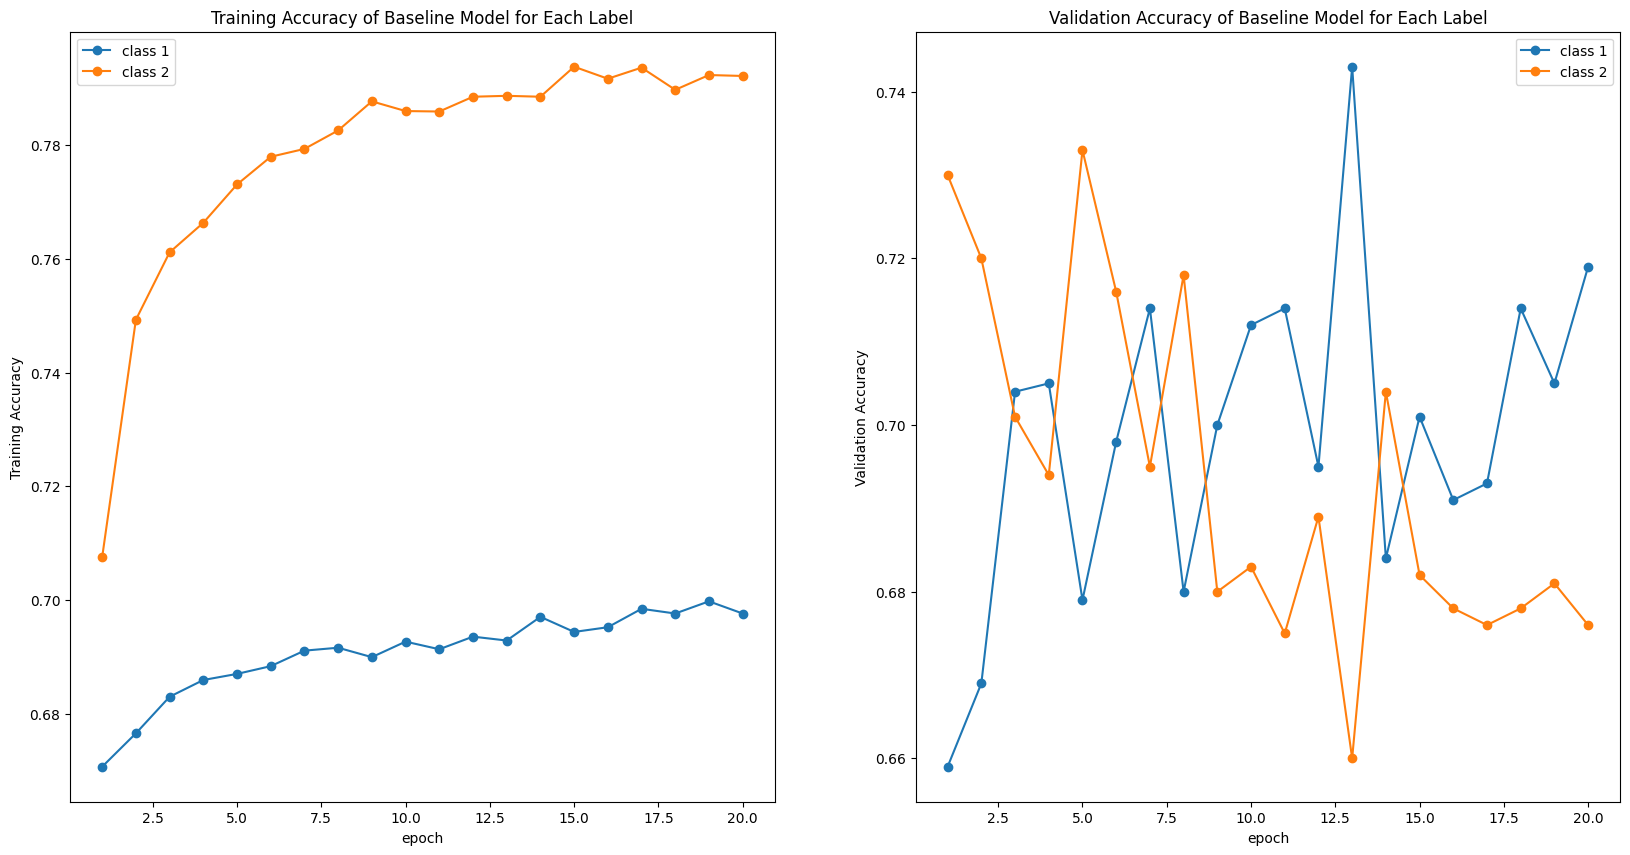

In [38]:
train_acc_labels = train_acc_label.transpose()
val_acc_labels = val_acc_label.transpose()

fig, axes = plt.subplots(1,2, figsize=(20,10))

epochs = np.linspace(1,20,20)
for label in range(train_acc_labels.shape[0]):
  axes[0].plot(epochs,train_acc_labels[label],"o-", label="class " + str(label + 1))
  axes[1].plot(epochs,val_acc_labels[label],"o-", label="class " + str(label + 1))

axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Training Accuracy")
axes[0].set_title("Training Accuracy of Baseline Model for Each Label")
axes[0].legend()

axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Validation Accuracy")
axes[1].set_title("Validation Accuracy of Baseline Model for Each Label")
axes[1].legend()

[Text(0.5, 1.0, 'ROC curve')]

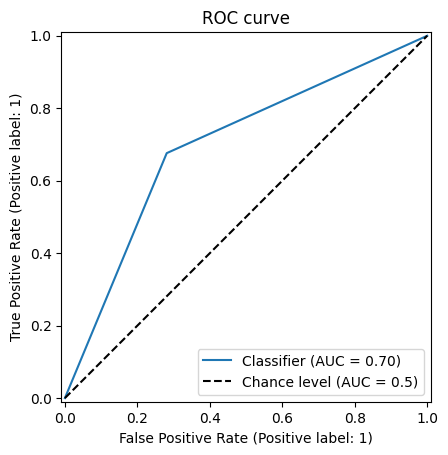

In [ ]:
roc_display = RocCurveDisplay.from_predictions(y_test, result, plot_chance_level=True)
roc_display.ax_.set(title="ROC curve")

[Text(0.5, 1.0, 'Precision vs Recall')]

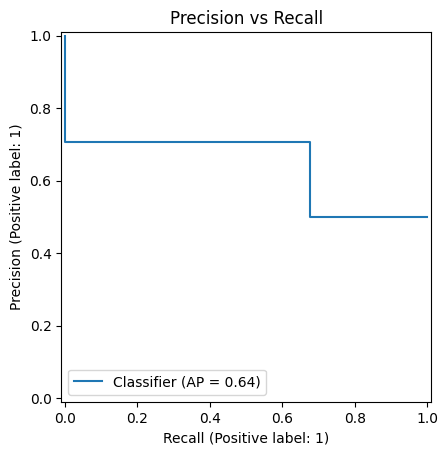

In [46]:
pr_display = PrecisionRecallDisplay.from_predictions(y_test, result)
pr_display.ax_.set(title="Precision vs Recall")